# Prediction of customers' travel pattern

# 1)-Importing key modules

In [1]:
import warnings
warnings.filterwarnings('ignore')
# For processing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import datetime as dt
from datetime import datetime
import seaborn as sns
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams["xtick.labelsize"] = 10
plt.figure(figsize=(16,10)) # this creates a figure 16 inch wide, 10 inch high
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# For modeling building and tunning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import Imputer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
# for deep learning if I will have time

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [4]:
# for evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [5]:
from datetime import date
import datetime as dt

# 2)-Loading data

In [6]:
df_travel = pd.read_csv('travel_data.csv')
df_travel.shape

(47007, 8)

In [7]:
df_travel.columns

Index(['event_type', 'user_id', 'origin', 'destination', 'distance',
       'num_family', 'ts_datetime', 'len_jour'],
      dtype='object')

In [8]:
df_travel.head()

,event_type,user_id,origin,destination,distance,num_family,ts_datetime,len_jour
0,search,60225f,PAR,NYC,5834.154716,7,2017-04-27 11:06:51,6.0
1,book,e5d69e,FRA,WAS,6525.926149,4,2017-04-27 20:15:27,21.0
2,book,f953f0,BER,CGN,469.781624,2,2017-04-27 23:03:43,3.0
3,book,794d35,BER,BCN,1498.817537,1,2017-04-27 15:17:50,3.0
4,book,ca4f94,DEL,BKK,2921.339028,4,2017-04-27 22:51:57,6.0


In [9]:
# Checking all variables with their data-type
def _tbl_dtype(dataset):
    sum_dtype = pd.DataFrame(dataset.dtypes).sort_values(0).rename(columns = {0:'Data Type'})
    return sum_dtype

table_dtype = _tbl_dtype(df_travel)
table_dtype

,Data Type
num_family,int64
distance,float64
len_jour,float64
event_type,object
user_id,object
origin,object
destination,object
ts_datetime,object


In [10]:
df_travel["ts_datetime"]=pd.to_datetime(df_travel.ts_datetime)

In [11]:
table_dtype = _tbl_dtype(df_travel)
table_dtype

,Data Type
num_family,int64
distance,float64
ts_datetime,datetime64[ns]
len_jour,float64
event_type,object
user_id,object
origin,object
destination,object


# 1)-working with ts_datetime

In [12]:
df_travel['ts_year']=df_travel.ts_datetime.dt.year
df_travel['ts_month']=df_travel.ts_datetime.dt.month
df_travel['ts_day']=df_travel.ts_datetime.dt.day
df_travel['ts_dayofweek']=df_travel.ts_datetime.dt.dayofweek
df_travel['ts_hour']=df_travel.ts_datetime.dt.hour

In [13]:
df_travel.head(2)

,event_type,user_id,origin,destination,distance,num_family,ts_datetime,len_jour,ts_year,ts_month,ts_day,ts_dayofweek,ts_hour
0,search,60225f,PAR,NYC,5834.154716,7,2017-04-27 11:06:51,6.0,2017,4,27,3,11
1,book,e5d69e,FRA,WAS,6525.926149,4,2017-04-27 20:15:27,21.0,2017,4,27,3,20


In [14]:
df_travel.ts_year.unique()

array([2017])

In [15]:
df_travel.ts_month.unique()

array([4, 5])

**Both month and year will not provide much of longitudnal(time related) information. Only we can see how much booking occured in month of April vs month of May**

In [16]:
len(df_travel[df_travel['ts_month']==4])

42512

In [17]:
len(df_travel[df_travel['ts_month']==5])

4495

In [20]:
df_travel.groupby(df_travel.ts_month).size()

ts_month
4    42512
5     4495
dtype: int64

In [21]:
dist=df_travel.ts_month.value_counts(ascending=True).sort_index()

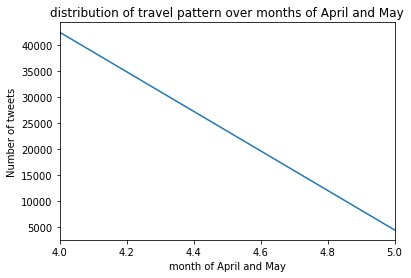

In [28]:
dist.plot()
plt.xlabel('month of April and May')
plt.ylabel('Number of online travel activities')
plt.title('distribution of travel pattern over months of April and May')
#plt.legend()
plt.show()

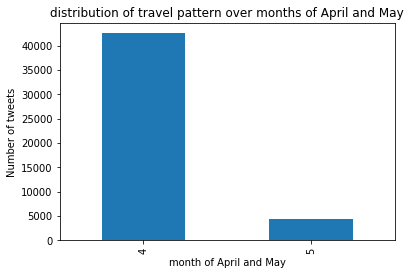

In [23]:
dist.plot(kind="bar")
plt.xlabel('month of April and May')
plt.ylabel('Number of online travel activities')
plt.title('distribution of travel pattern over months of April and May')
#plt.legend()
plt.show()

We have not got very useful information there. There is no lineplot that I am used to see for time series.

Let's try other time values

In [26]:
dist2=df_travel.ts_hour.value_counts(ascending=True).sort_index()
dist2

0     3506
1     3009
2     1841
3      918
4      468
5      232
6      124
7       98
8      131
9      294
10     655
11    1240
12    1973
13    2557
14    2758
15    2803
16    2870
17    3059
18    2876
19    2879
20    3053
21    3127
22    3124
23    3412
Name: ts_hour, dtype: int64

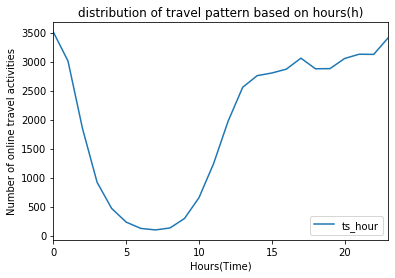

In [31]:
dist2.plot()
plt.xlabel('Hours(Time)')
plt.ylabel('Number of online travel activities')
plt.title('distribution of travel pattern based on hours(h)')
#plt.legend()
plt.show()

We can that during morning time i.e 5-10 , there is not much happening. Plot reached its lowest

As we move in working hours , there are more activities. High point approaches after 20:00 i.e 8 pm. This does information about peak and low for online activities. 

**END OF NOTEBOOK2**